In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import ToPILImage
from IPython.display import display
import math

# Forward process

In [2]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader


# beta scheduler
def linear_beta_schedule(timesteps, start = 0.0001, end=0.02):
    return torch.linspace(start, end, timesteps) 

def cosine_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    betas = torch.linspace(0, 1, timesteps)
    betas = 0.5 * (1 + torch.cos(betas * math.pi))
    betas = start + (end - start) * betas
    return betas

'''
특정 timestep t에서의 값을 가져오기 위한 장치
vals: timestep에 다라 변하는 값을 가진 리스트 (2차원)
t: 특정 timestep의 시간을 나타내는 tensor (2차원)
'''
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0] # t는 embedding된 timestep의 tensor
    out = vals.gather(-1, t.cpu())  # t에 해당하는 값을 가져옴.
    
    return out.reshape(batch_size, *((1, ) * (len(x_shape) - 1))).to(t.device) # out tensor의 형태를 조정. (batch_size, 1,1,1,...,1) 로 바꿔서 x_0와 동일한 형태


# x_0와 timestep T를 input으로 받고 noise로 만들기
def forward_diffusion_sample(x_0, t, device="cpu"):
    
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 1000 # timestep T
betas = linear_beta_schedule(timesteps=T)

alphas = 1 - betas  
alphas_cumprod = torch.cumprod(alphas, axis=0) # noise 크기의 누적 변화
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1) # 이전 timestep 값
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # 1 / alpha = noise의 variance 
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # alphas_cumprod: noise 크기의 누적 변화 (\Pi alpha)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod) 
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)

In [3]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 32 # CIFAR-10 이미지 크기는 32x32입니다.
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # 데이터를 [0,1] 범위로 조정합니다.
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # CIFAR-10 데이터의 평균 및 표준편차로 정규화합니다.
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.CIFAR10(root="./dataset", train=True, download=True, transform=data_transform)
    test = torchvision.datasets.CIFAR10(root="./dataset", train=False, download=True, transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Normalize((-1, -1, -1), (2, 2, 2)), # [-1, 1] 범위로 복원합니다.
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW를 HWC로 변환합니다.
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # 배치의 첫 번째 이미지를 사용합니다.
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


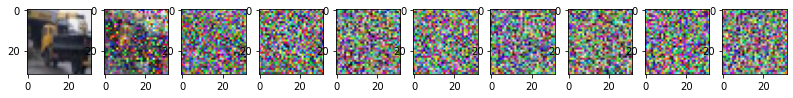

In [4]:
# Simulate forward diffusion
x_0 = next(iter(dataloader))[0]
x_t = [] 

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(x_0, t)
    x_t.append(img)
    show_tensor_image(img)

# 마지막 noisy 이미지를 x_T로 설정합니다.
x_T = x_t[-1]


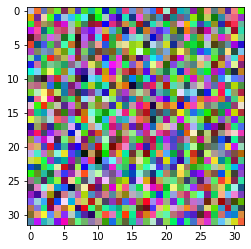

In [5]:
show_tensor_image(x_T)

## Denoising with $x_0$
### 7/11

In [6]:
""" 
7/11
원래 denoising : x_{t-1} = x_t + sqrt(alpha_t) * noise
x_0를 condition: x_{t-1} = x_t + sqrt(alpha_t) * noise + sqrt(1 - alpha_t) * (x_0 - x_t)
"""


' \n7/11\n원래 denoising : x_{t-1} = x_t + sqrt(alpha_t) * noise\nx_0를 condition: x_{t-1} = x_t + sqrt(alpha_t) * noise + sqrt(1 - alpha_t) * (x_0 - x_t)\n'

-----

In [6]:
def reverse_process(x_T, x_0):
    x_t = x_T

    for idx in range(T-1, -1, -1):
        t = torch.Tensor([idx]).type(torch.int64)
        sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape) # t에 해당하는 값 가져오기. 노이즈 크기 누적변화
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape) # 노이즈 크기의 변화
        noise = (x_t - sqrt_alphas_cumprod_t * x_0) / sqrt_one_minus_alphas_cumprod_t # 현재 timestep에서 denoising 된 값
        x_t = noise

    return x_t

In [7]:
def reverse_process(x_T, x_0):
    x_t = x_T
    denoised_images = []

    for idx in range(T-1, -1, -1):
        t = torch.Tensor([idx]).type(torch.int64)
        sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        noise = (x_t - sqrt_alphas_cumprod_t * x_0) / sqrt_one_minus_alphas_cumprod_t
        x_t = noise

        # 중간 단계의 이미지 저장
        if idx % (T // 10) == 0:
            denoised_images.append(x_t.clone())

    return denoised_images


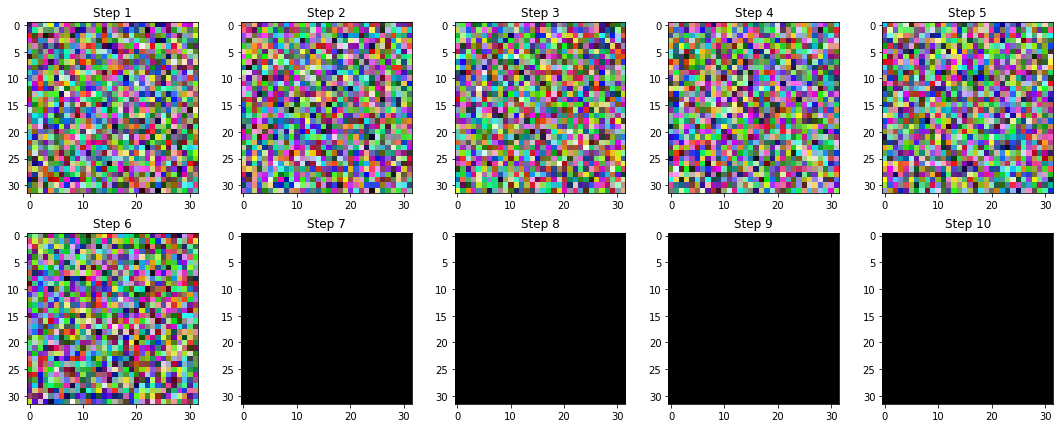

In [8]:
# reverse_process 함수 호출
denoised_images = reverse_process(x_T, x_0)

# 추출된 이미지 시각화
plt.figure(figsize=(15, 6))
for i in range(len(denoised_images)):
    plt.subplot(2, 5, i+1)
    show_tensor_image(denoised_images[i])
    plt.title(f"Step {i+1}")
plt.tight_layout()
plt.show()

## Reverse process

$$ p_\theta(x_{0:T}) \Pi^T_{t=1} p_\theta(x_{t-1}|x_t) $$

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False): # input channel: in_ch, output channel: out_ch, time_emb_dim: time embedding dimension
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch) # time embedding dimension을 output dimension의 channel수로 변환
        if up: # upsampling
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else: # downsampling
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [ ]:
class Unet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 # 최종 출력 채널 수
        time_emb_dim = 32 # time embedding dimension

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1) 

    # input image x: noisy image
    def forward(self, x, x_0, timestep): 
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs: # downsampling
            x = down(x, t)
            residual_inputs.append(x) # upsampling
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        
        # # x_0 추가
        # x = torch.cat((x, x_0), dim = 1)
        
        return self.output(x)

model = Unet()

In [ ]:
# p